### Random Forest Notebook

This Notebook is to model the random forest regression to predict the incidence value in Switzerland and Swiss regions.

lags fixen (incValue statt popValue)

die ganzen real time data raushauen, stattdessen lags.

probieren mit verschiedenen lags (52 week lag erstmal und dann gucken, vor allem wegen wetter, pop)


data leakage problem:
- 

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import json
from datetime import datetime

### Some Data Preparation

In [171]:
# start modelling here
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

In [172]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [173]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu_data['Woche'] = google_flu_data['Woche'].apply(lambda x: date_dict[x])
google_symptoms_data['Woche'] = google_symptoms_data['Woche'].apply(lambda x: date_dict[x])

In [174]:
dates = weather_data.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather_data['date'] = iso_week_dates

In [175]:
# Reshape google_flu from wide to long
google_flu_data = google_flu_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu_data['region'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu_data['query'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu_data = google_flu_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [176]:
# Reshape google_flu from wide to long
google_symptoms_data = google_symptoms_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms_data['region'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms_data['query'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms_data = google_symptoms_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [177]:
merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [178]:
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Woche,region_y,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,2013-W02,region_1,6.694163,-1.180241,-2.182889,10.057294,13.364971,0.507812,5.565260,7.291899,12.730951,0.035270,4.986369,7.709312,0.000000,-0.266457,-4.918594,5.185051,14.012359,-2.413512,3.443423,12.982448,25.224384,-2.570827,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,2013-W03,region_1,15.731896,2.856978,2.868328,10.006590,8.495091,0.808069,0.435401,7.251621,16.742543,-0.024616,9.084647,7.682512,0.000000,-2.191639,-3.071684,5.263323,31.712181,4.514063,14.247842,12.950276,15.337335,0.254120,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,2013-W04,region_1,12.886953,0.545618,2.385324,9.956011,13.066783,1.211959,4.643270,7.211554,18.003596,0.563415,9.784405,7.655776,11.763678,6.478843,-0.056714,5.341549,14.719024,1.562238,0.238883,12.917902,13.586975,-3.277945,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188
4,2013-W05,region_1,39004.7,502.50,region_1,2013-W05,4.551592,78.802057,7.993836,0.627968,92.950733,58.114673,2013-W05,region_1,20.251145,0.132748,10.212838,9.905558,11.777776,0.883827,3.722246,7.171703,16.342096,0.109972,8.603017,7.629107,0.000000,-0.579764,-4.839965,5.419729,10.902479,-2.175490,0.192648,12.885322,31.616718,3.240345,8.369157,20.007216,3.797554,-6.717551,3.014675,7.500430,11.163364,-1.808321,-1.522283,14.493968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,region_6,2023-W42,8.779691,86.279860,112.068950,15.165819,16.738540,17.896114,2023-W42,region_6,0.000000,-8.418317,3.801028,4.617289,4.557310,-5.055933,2.571402,7.041841,15.830161,10.048946,-1.631333,7.412548,4.567539,0.843819,-2.860805,6.584525,0.000000,-3.507947,-11.320733,14.828679,0.000000,0.000000,0.000000,0.000000,14.808454,7.342648,-4.320877,11.786683,0.000000,-0.022954,-0.426565,0.449520
3404,2023-W43,region_6,13789.4,116.03,region_6,2023-W43,8.713151,90.941844,146.785800,14.580323,16.035777,6.764381,2023-W43,region_6,0.000000,-0.012139,-4.621183,4.633322,6.165772,-4.893040,3.998443,7.060370,8.287688,1.947735,-1.066951,7.406904,9.447745,-1.144149,4.021414,6.570481,15.541432,2.531880,-1.895107,14.904660,0.000000,0.000000,0.000000,0.000000,5.925534,-0.478980,-5.410189,11.814702,0.000000,-0.171670,-0.269120,0.440791
3405,2023-W44,region_6,9232.8,54.15,region_6,2023-W44,5.359404,93.029671,113.603722,11.504548,19.159654,16.889149,2023-W44,region_6,0.000000,0.016777,-4.666138,4.649361,12.063468,2.570481,2.414204,7.078782,5.715134,-0.174347,-1.511699,7.401180,2.569241,-1.372037,-2.614902,6.556180,13.187346,2.998214,-4.791817,14.980949,0.000000,0.000000,0.000000,0.000000,

In [179]:
pop_data

,region,Jahr-Woche,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche,Bevölkerung,% over week,Pop Density
0,CH,2013-W01,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633081.0,4990935.0,1415044.0,3972395.0,4066665.0,6125552.0,1913508.0,3494124.0,3484339.0,402630.0,644545.0,521.0,12024.0,877.0,5043379.0,1745310.0,1250371.0,654611.66897,1.70375,1.79214,80422.769653,1,8.039060e+06,NaN,194.721085
1,CH,2013-W02,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633481.0,4992159.0,1415391.0,3973370.0,4067662.0,6127054.0,1913978.0,3494982.0,3485194.0,402729.0,644703.0,522.0,12027.0,877.0,5044616.0,1745738.0,1250678.0,654611.66897,1.70375,1.79214,80422.769653,2,8.041032e+06,0.024530,194.768850
2,CH,2013-W03,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633882.0,4993383.0,1415739.0,3974344.0,4068660.0,6128557.0,1914447.0,3495839.0,3486048.0,402828.0,644861.0,522.0,12029.0,877.0,5045853.0,1746166.0,1250985.0,654611.66897,1.70375,1.79214,80422.769653,3,8.043004e+06,0.024524,194.816615
3,CH,2013-W04,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1634282.0,4994608.0,1416086.0,3975318.0,4069657.0,6130059.0,1914917.0,3496696.0,3486903.0,402926.0,645019.0,522.0,12032.0,878.0,5047090.0,1746594.0,1251292.0,654611.66897,1.70375,1.79214,80422.769653,4,8.044976e+06,0.024518,194.864380
4,CH,2013-W05,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1634683.0,4995832.0,1416433.0,3976293.0,4070655.0,6131562.0,1915386.0,3497553.0,3487758.0,403025.0,645177.0,522.0,12035.0,878.0,5048327.0,1747022.0,1251598.0,654611.66897,1.70375,1.79214,80422.769653,5,8.046948e+06,0.024512,194.912145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,region_6,2022-W48,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97501.0,329265.0,129560.0,273981.0,282345.0,417106.0,139219.0,240104.0,233029.0,32080.0,50368.0,58.0,546.0,134.0,318194.0,101541.0,136591.0,0.00000,NaN,NaN,NaN,48,5.563254e+05,0.010732,77.169713
3650,region_6,2022-W49,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97511.0,329299.0,129573.0,274010.0,282374.0,417150.0,139235.0,240130.0,233054.0,32083.0,50373.0,58.0,546.0,134.0,318228.0,101551.0,136605.0,0.00000,NaN,NaN,NaN,49,5.563843e+05,0.010730,77.177739
3651,region_6,2022-W50,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97521.0,329334.0,129588.0,274039.0,282404.0,417194.0,139249.0,240155.0,233078.0,32088.0,50378.0,58.0,546.0,134.0,318261.0,101561.0,136621.0,0.00000,NaN,NaN,NaN,50,5.564432e+05,0.010729,77.185764
3652,region_6,2022-W51,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97532.0,329369.0,129601.0,274068.0,282434.0,417239.0,139264.0,240180.0,233103.0,32091.0,50384.0,58.0,546.0,134.0,318294.0,101572.0,136635.0,0.00000,NaN,NaN,NaN,51,5.565021e+05,0.010728,77.193790


In [180]:
merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Woche_x,region_y,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Jahr-Woche,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche_y,Bevölkerung,% over week,Pop Density
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,region_1,2013-W01,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,365930.0,1042917.0,284897.0,827791.0,865952.0,1150475.0,543268.0,751566.0,712209.0,81724.0,145117.0,141.0,2784.0,202.0,1148298.0,371174.0,174271.0,134909.54871,0.532745,0.486882,78683.84215,1.0,1.693743e+06,NaN,537.516672
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,2013-W02,region_1,6.694163,-1.180241,-2.182889,10.057294,13.364971,0.507812,5.565260,7.291899,12.730951,0.035270,4.986369,7.709312,0.000000,-0.266457,-4.918594,5.185051,14.012359,-2.413512,3.443423,12.982448,25.224384,-2.570827,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910,region_1,2013-W02,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366050.0,1043260.0,284991.0,828064.0,866237.0,1150855.0,543446.0,751814.0,712444.0,81751.0,145164.0,142.0,2785.0,202.0,1148670.0,371301.0,174331.0,134909.54871,0.532745,0.486882,78683.84215,2.0,1.694301e+06,0.029959,537.665907
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,2013-W03,region_1,15.731896,2.856978,2.868328,10.006590,8.495091,0.808069,0.435401,7.251621,16.742543,-0.024616,9.084647,7.682512,0.000000,-2.191639,-3.071684,5.263323,31.712181,4.514063,14.247842,12.950276,15.337335,0.254120,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839,region_1,2013-W03,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366172.0,1043604.0,285083.0,828336.0,866522.0,1151234.0,543625.0,752062.0,712678.0,81778.0,145211.0,142.0,2786.0,202.0,1149040.0,371429.0,174392.0,134909.54871,0.532745,0.486882,78683.84215,3.0,1.694860e+06,0.029950,537.815142
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,2013-W04,region_1,12.886953,0.545618,2.385324,9.956011,13.066783,1.211959,4.643270,7.211554,18.003596,0.563415,9.784405,7.655776,11.763678,6.478843,-0.056714,5.341549,14.719024,1.562238,0.238883,12.917902,13.586975,-3.277945,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188,region_1,2013-W04,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366293.0,1043949.0,285178.0,828611.0,866809.0,1151614.0,543804.0,752310.0,712915.0,81805.0,145258.0,142.0,2786.0,202.0,1149412.0,371555.0,174451.0,134909.54871,0.532745,0.486882,78683.84215,4.0,1.695418e+06,0.029941,53

In [181]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'region_x', 'date',
       'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche_x',
       'region_y', 'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend', 'region', 'Jahr-Woche',
       'Bevölkerung 1. Januar', 'Geburten', 'Todesfälle', 'Überschuss',
       'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal',
 

In [182]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)

In [183]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [184]:
merged_data

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Bevölkerung,% over week,Pop Density
0,2013-W01,region_1,16876.1,53.33,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,365930.0,1042917.0,284897.0,827791.0,865952.0,1150475.0,543268.0,751566.0,712209.0,81724.0,145117.0,141.0,2784.0,202.0,1148298.0,371174.0,174271.0,134909.54871,0.532745,0.486882,78683.84215,1.693743e+06,NaN,537.516672
1,2013-W02,region_1,33045.6,114.99,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,6.694163,-1.180241,-2.182889,10.057294,13.364971,0.507812,5.565260,7.291899,12.730951,0.035270,4.986369,7.709312,0.000000,-0.266457,-4.918594,5.185051,14.012359,-2.413512,3.443423,12.982448,25.224384,-2.570827,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,366050.0,1043260.0,284991.0,828064.0,866237.0,1150855.0,543446.0,751814.0,712444.0,81751.0,145164.0,142.0,2785.0,202.0,1148670.0,371301.0,174331.0,134909.54871,0.532745,0.486882,78683.84215,1.694301e+06,0.029959,537.665907
2,2013-W03,region_1,37204.9,185.46,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,15.731896,2.856978,2.868328,10.006590,8.495091,0.808069,0.435401,7.251621,16.742543,-0.024616,9.084647,7.682512,0.000000,-2.191639,-3.071684,5.263323,31.712181,4.514063,14.247842,12.950276,15.337335,0.254120,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,366172.0,1043604.0,285083.0,828336.0,866522.0,1151234.0,543625.0,752062.0,712678.0,81778.0,145211.0,142.0,2786.0,202.0,1149040.0,371429.0,174392.0,134909.54871,0.532745,0.486882,78683.84215,1.694860e+06,0.029950,537.815142
3,2013-W04,region_1,36421.1,307.51,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,12.886953,0.545618,2.385324,9.956011,13.066783,1.211959,4.643270,7.211554,18.003596,0.563415,9.784405,7.655776,11.763678,6.478843,-0.056714,5.341549,14.719024,1.562238,0.238883,12.917902,13.586975,-3.277945,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,366293.0,1043949.0,285178.0,828611.0,866809.0,1151614.0,543804.0,752310.0,712915.0,81805.0,145258.0,142.0,2786.0,202.0,1149412.0,371555.0,174451.0,134909.54871,0.532745,0.486882,78683.84215,1.695418e+06,0.029941,537.964377
4,2013-W05,region_1,39004.7,502.50,4.551592,78.802057,7.993836,0.627968,92.950733,58.114673,20.251145,0.132748,10.212838,9.905558,11.777776,0.883827,3.722246,7.171703,16.342096,0.109972,8.603017,7.629107,0.000000,-0.579764,-4.839965,5.419729,10.902479,-2.175490,0.192648,12.885322,31.616718,3

In [185]:
# lags um 52 wochen auf alle Spalten
exogenous_columns = [
    'weighted_avg_daily_temp', 'weighted_avg_daily_hum', 'weighted_max_daily_temp', 
    'weighted_min_daily_temp', 'weighted_max_daily_hum', 'weighted_min_daily_hum', 
    'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe', 'Grippe_resid', 
    'Grippe_seasonal', 'Grippe_trend', 'Influenza', 'Influenza_resid', 'Influenza_seasonal', 
    'Influenza_trend', 'influenza', 'influenza_resid', 'influenza_seasonal', 'influenza_trend', 
    'Fieber', 'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre', 'fièvre_resid', 
    'fièvre_seasonal', 'fièvre_trend', 'husten', 'husten_resid', 'husten_seasonal', 'husten_trend', 
    'toux', 'toux_resid', 'toux_seasonal', 'toux_trend', 'Geburten', 
    'Todesfälle', 'Überschuss', 'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal', 
    'total', '% over Year', 'Alter 0–19', 'Alter 20–64', 'Alter 65 und mehr', 
    'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig', 'Verheiratet', 'Verwitwet', 'Geschieden', 
    'Unverheiratet', 'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft', 'Städtischer Kernraum', 
    'Einflussgebiet Stadt', 'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF', 
    'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr', 'BIP pro Kopf', 'Bevölkerung', 
    '% over week', 'Pop Density'
]

merged_data.drop(columns=['region'], inplace=True)
lagged_df = merged_data.copy()
# Anwenden des Lags
for column in exogenous_columns:
    lagged_df[column + '_lagged'] = lagged_df.groupby('georegion')[column].shift(52)
    lagged_df.drop(columns=column, inplace=True)

lagged_df

,temporal,georegion,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,weighted_min_daily_hum_lagged,Flu_lagged,Flu_resid_lagged,Flu_seasonal_lagged,Flu_trend_lagged,Grippe_lagged,Grippe_resid_lagged,Grippe_seasonal_lagged,Grippe_trend_lagged,Influenza_lagged,Influenza_resid_lagged,Influenza_seasonal_lagged,Influenza_trend_lagged,influenza_lagged,influenza_resid_lagged,influenza_seasonal_lagged,influenza_trend_lagged,Fieber_lagged,Fieber_resid_lagged,Fieber_seasonal_lagged,Fieber_trend_lagged,fièvre_lagged,fièvre_resid_lagged,fièvre_seasonal_lagged,fièvre_trend_lagged,husten_lagged,husten_resid_lagged,husten_seasonal_lagged,husten_trend_lagged,toux_lagged,toux_resid_lagged,toux_seasonal_lagged,toux_trend_lagged,Geburten_lagged,Todesfälle_lagged,Überschuss_lagged,Wanderungssaldo international 1_lagged,Wanderungssaldo interkantonal_lagged,total_lagged,% over Year_lagged,Alter 0–19_lagged,Alter 20–64_lagged,Alter 65 und mehr_lagged,Mann_lagged,Frau_lagged,Schweizer_lagged,Ausländer _lagged,Ledig_lagged,Verheiratet_lagged,Verwitwet_lagged,Geschieden_lagged,Unverheiratet_lagged,In eingetragener Partnerschaft_lagged,Aufgelöste Partnerschaft_lagged,Städtischer Kernraum_lagged,Einflussgebiet Stadt_lagged,Ausserhalb des Einflusses städtischer Kerne_lagged,BIP in Millionen CHF_lagged,BIP Growth Laufende Preise_lagged,BIP Growth Preise Vorjahr_lagged,BIP pro Kopf_lagged,Bevölkerung_lagged,% over week_lagged,Pop Density_lagged
0,2013-W01,region_1,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-W02,region_1,33045.6,114.99,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-W03,region_1,37204.9,185.46,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-W04,region_1,36421.1,307.51,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-W05,region_1,39004.7,502.50,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,NaN,NaN,14.699677,79.160694,18.855427,11.624484,92.557691,59.574738,4.240032,-3.759416,4.211918,3.787529,11.292177,2.575190,2.600485,6.116503,5.725931,-2.093526,0.392730,7.426726,3.305010,-1.710873,-1.735809,6.751692,5.022407,0.167208,-6.651277,11.506476,0.0,0.0,0.0,0.0,0.000000,-7.178122,-3.032646,10.210769,0.000000,-0.076397,-0.806202,0.882599,79.0,106.0,-28.0,87.0,2.0,57.0,0.550028,97439.0,329055.0,129478.0,273807

In [186]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

arma_data = merged_data.copy()

# Teilen Sie den DataFrame in Trainings- und Testdaten
train_size = int(len(arma_data) * 0.9)
train_data = arma_data.iloc[:train_size]
test_data = arma_data.iloc[train_size:]

for column in exogenous_columns:
    model = ARIMA(train_data[column], order=(5,1,0))  # Parameter anpassen
    fitted_model = model.fit()

    # Länge des Testdatensatzes
    test_length = len(test_data)

    # Vorhersagen für den Testzeitraum
    predictions = fitted_model.forecast(steps=test_length)

    # Hinzufügen der Vorhersagen zum Testdatensatz
    test_data[column + '_predicted'] = predictions


/var/folders/1s/ty3k5htx7f75_wdj8mxbv_vw0000gn/T/ipykernel_42126/2582297544.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[column + '_predicted'] = predictions
/var/folders/1s/ty3k5htx7f75_wdj8mxbv_vw0000gn/T/ipykernel_42126/2582297544.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[column + '_predicted'] = predictions
/var/folders/1s/ty3k5htx7f75_wdj8mxbv_vw0000gn/T/ipykernel_42126/2582297544.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [187]:
test_data

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Bevölkerung,% over week,Pop Density,weighted_avg_daily_temp_predicted,weighted_avg_daily_hum_predicted,weighted_max_daily_temp_predicted,weighted_min_daily_temp_predicted,weighted_max_daily_hum_predicted,weighted_min_daily_hum_predicted,Flu_predicted,Flu_resid_predicted,Flu_seasonal_predicted,Flu_trend_predicted,Grippe_predicted,Grippe_resid_predicted,Grippe_seasonal_predicted,Grippe_trend_predicted,Influenza_predicted,Influenza_resid_predicted,Influenza_seasonal_predicted,Influenza_trend_predicted,influenza_predicted,influenza_resid_predicted,influenza_seasonal_predicted,influenza_trend_predicted,Fieber_predicted,Fieber_resid_predicted,Fieber_seasonal_predicted,Fieber_trend_predicted,fièvre_predicted,fièvre_resid_predicted,fièvre_seasonal_predicted,fièvre_trend_predicted,husten_predicted,husten_resid_predicted,husten_seasonal_predicted,husten_trend_predicted,toux_predicted,toux_resid_predicted,toux_seasonal_predicted,toux_trend_predicted,Geburten_predicted,Todesfälle_predicted,Überschuss_predicted,Wanderungssaldo international 1_predicted,Wanderungssaldo interkantonal_predicted,total_predicted,% over Year_predicted,Alter 0–19_predicted,Alter 20–64_predicted,Alter 65 und mehr_predicted,Mann_predicted,Frau_predicted,Schweizer_predicted,Ausländer _predicted,Ledig_predicted,Verheiratet_predicted,Verwitwet_predicted,Geschieden_predicted,Unverheiratet_predicted,In eingetragener Partnerschaft_predicted,Aufgelöste Partnerschaft_predicted,Städtischer Kernraum_predicted,Einflussgebiet Stadt_predicted,Ausserhalb des Einflusses städtischer Kerne_predicted,BIP in Millionen CHF_predicted,BIP Growth Laufende Preise_predicted,BIP Growth Preise Vorjahr_predicted,BIP pro Kopf_predicted,Bevölkerung_predicted,% over week_predicted,Pop Density_predicted
3067,2017-W19,region_6,17754.3,0.00,13.999813,65.559997,19.212857,10.043068,86.784691,44.635780,0.000000,-0.009707,-1.744395,1.754102,0.000000,-3.253041,-2.068538,5.321579,0.000000,-0.285292,-7.105484,7.390776,0.000000,-1.282350,-3.047057,4.329407,0.000000,-5.732633,-2.043793,7.776426,0.0,0.0,0.0,0.0,8.336189,3.709384,-0.123293,4.750098,0.000000,0.116060,-1.345360,1.229300,551925.0,86.0,96.0,-10.0,30.0,-26.0,-7.0,-0.00842,9917.0,100708.0,330802.0,120299.0,271656.0,280154.0,416240.0,135569.0,232030.0,241450.0,32139.0,45483.0,53.0,585.0,60.0,316386.0,100344.0,135079.0,43416.61191,-0.361315,-0.04955,77103.169445,551809.235294,-0.000167,76.879983,9.145677,65.597590,15.106099,4.912465,91.608329,43.357597,8.174992,2.800382,3.028311,1.754101,0.518377,0.019045,-4.879450,5.320592,1.920443,-0.955018,-4.278219,7.391270,2.768768,0.503179,-1.762699,4.326101,5.684993,-1.318112,-0.401921,7.775519,5.928788e-323,-6.422853e-323,4.940656e-324,0.0,3.475571,-2.375293,1.105334,4.736270,5.775185,5.393978,-1.234954,1.229549,86.0,96.0,-10.0,30.0,-26.0,-7.0,-0.00842,100708.078315,330805.361559,120300.239789,271658.319505,280155.325571,416243.225912,135571.481136,2

Other stuff

In [193]:
lagged_df['incValue'].interpolate(inplace=True)

# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
lagged_df['week_number'] = lagged_df['temporal'].str.extract(pattern).astype(int)

lagged_df['year'] = lagged_df['temporal'].apply(lambda x: x.split('-')[0])
lagged_df['year'] = pd.to_numeric(lagged_df['year'])

# Convert from iso-calendar week to dates
lagged_df['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), lagged_df['year'], lagged_df['week_number']))

In [195]:
lagged_df.set_index('date', inplace=True)

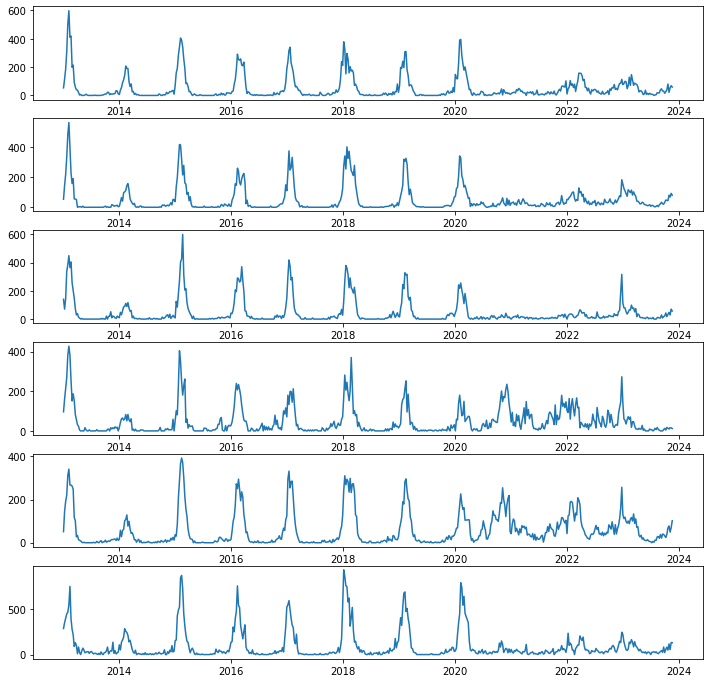

In [196]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(lagged_df.loc[lagged_df['georegion'] == f"region_{i}", 'incValue'])

### Some Feature Engineering

In [197]:
# create 1 year lag for flu cases
lagged_df['flu_cases_lagged'] = lagged_df.groupby('georegion')['flu_cases'].shift(52)
lagged_df

,temporal,georegion,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,weighted_min_daily_hum_lagged,Flu_lagged,Flu_resid_lagged,Flu_seasonal_lagged,Flu_trend_lagged,Grippe_lagged,Grippe_resid_lagged,Grippe_seasonal_lagged,Grippe_trend_lagged,Influenza_lagged,Influenza_resid_lagged,Influenza_seasonal_lagged,Influenza_trend_lagged,influenza_lagged,influenza_resid_lagged,influenza_seasonal_lagged,influenza_trend_lagged,Fieber_lagged,Fieber_resid_lagged,Fieber_seasonal_lagged,Fieber_trend_lagged,fièvre_lagged,fièvre_resid_lagged,fièvre_seasonal_lagged,fièvre_trend_lagged,husten_lagged,husten_resid_lagged,husten_seasonal_lagged,husten_trend_lagged,toux_lagged,toux_resid_lagged,toux_seasonal_lagged,toux_trend_lagged,Geburten_lagged,Todesfälle_lagged,Überschuss_lagged,Wanderungssaldo international 1_lagged,Wanderungssaldo interkantonal_lagged,total_lagged,% over Year_lagged,Alter 0–19_lagged,Alter 20–64_lagged,Alter 65 und mehr_lagged,Mann_lagged,Frau_lagged,Schweizer_lagged,Ausländer _lagged,Ledig_lagged,Verheiratet_lagged,Verwitwet_lagged,Geschieden_lagged,Unverheiratet_lagged,In eingetragener Partnerschaft_lagged,Aufgelöste Partnerschaft_lagged,Städtischer Kernraum_lagged,Einflussgebiet Stadt_lagged,Ausserhalb des Einflusses städtischer Kerne_lagged,BIP in Millionen CHF_lagged,BIP Growth Laufende Preise_lagged,BIP Growth Preise Vorjahr_lagged,BIP pro Kopf_lagged,Bevölkerung_lagged,% over week_lagged,Pop Density_lagged,week_number,year,flu_cases_lagged
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-03,2013-W01,region_1,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN
2013-01-10,2013-W02,region_1,33045.6,114.99,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2013,NaN
2013-01-17,2013-W03,region_1,37204.9,185.46,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2013,NaN
2013-01-24,2013-W04,region_1,36421.1,307.51,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2013,NaN
2013-01-31,2013-W05,region_1,39004.7,502.50,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,2023-W42,region_6,14349.7,48.78,NaN,NaN,14.699677,79.160694,18.855427,11.624484,92.557691,59.574738,4.240032,-3.759416,4.211918,3.787529,11.292177,2.575190,2.600485,6.116503,5.725931,-2.093526,0.392730,7.426726,3.3050

In [199]:
# dummies aus georegion machen
df_lagged_with_dummies = pd.get_dummies(lagged_df, columns=['georegion'], drop_first=False)
df_lagged_with_dummies

,temporal,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,weighted_min_daily_hum_lagged,Flu_lagged,Flu_resid_lagged,Flu_seasonal_lagged,Flu_trend_lagged,Grippe_lagged,Grippe_resid_lagged,Grippe_seasonal_lagged,Grippe_trend_lagged,Influenza_lagged,Influenza_resid_lagged,Influenza_seasonal_lagged,Influenza_trend_lagged,influenza_lagged,influenza_resid_lagged,influenza_seasonal_lagged,influenza_trend_lagged,Fieber_lagged,Fieber_resid_lagged,Fieber_seasonal_lagged,Fieber_trend_lagged,fièvre_lagged,fièvre_resid_lagged,fièvre_seasonal_lagged,fièvre_trend_lagged,husten_lagged,husten_resid_lagged,husten_seasonal_lagged,husten_trend_lagged,toux_lagged,toux_resid_lagged,toux_seasonal_lagged,toux_trend_lagged,Geburten_lagged,Todesfälle_lagged,Überschuss_lagged,Wanderungssaldo international 1_lagged,Wanderungssaldo interkantonal_lagged,total_lagged,% over Year_lagged,Alter 0–19_lagged,Alter 20–64_lagged,Alter 65 und mehr_lagged,Mann_lagged,Frau_lagged,Schweizer_lagged,Ausländer _lagged,Ledig_lagged,Verheiratet_lagged,Verwitwet_lagged,Geschieden_lagged,Unverheiratet_lagged,In eingetragener Partnerschaft_lagged,Aufgelöste Partnerschaft_lagged,Städtischer Kernraum_lagged,Einflussgebiet Stadt_lagged,Ausserhalb des Einflusses städtischer Kerne_lagged,BIP in Millionen CHF_lagged,BIP Growth Laufende Preise_lagged,BIP Growth Preise Vorjahr_lagged,BIP pro Kopf_lagged,Bevölkerung_lagged,% over week_lagged,Pop Density_lagged,week_number,year,flu_cases_lagged,georegion_region_1,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-03,2013-W01,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,True,False,False,False,False,False
2013-01-10,2013-W02,33045.6,114.99,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2013,NaN,True,False,False,False,False,False
2013-01-17,2013-W03,37204.9,185.46,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2013,NaN,True,False,False,False,False,False
2013-01-24,2013-W04,36421.1,307.51,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2013,NaN,True,False,False,False,False,False
2013-01-31,2013-W05,39004.7,502.50,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2013,NaN,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [201]:
df_lagged_with_dummies.incValue.mean()

57.76767018779343

### Some Modelling YAY

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

df_lagged_with_dummies.sort_index(inplace=True)

X = df_lagged_with_dummies.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values  # Features
y = df_lagged_with_dummies['incValue'].values  # Target

# Datenaufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Modellerstellung
regressor = DecisionTreeRegressor()

# Training des Modells
regressor.fit(X_train, y_train)

# Vorhersagen auf dem Testset
predictions = regressor.predict(X_test)

# Bewertung des Modells
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
print(f"RMSE: {rmse_train}")
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
print(f"RMSE: {rmse_test}")

# Weitere Schritte können das Feintunen des Modells und das Experimentieren mit anderen Modellen umfassen.


RMSE: 57.64755800699079
RMSE: 48.0678910772361


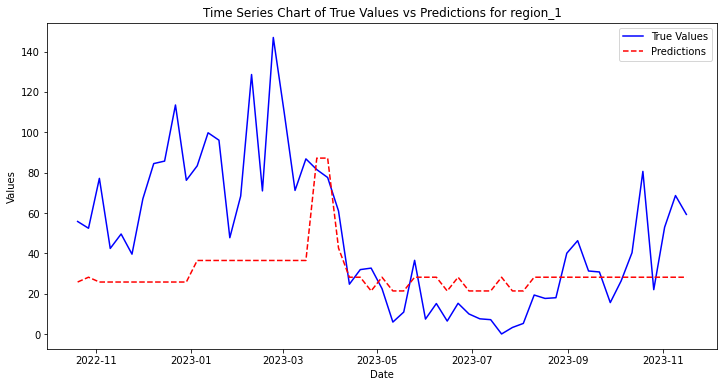

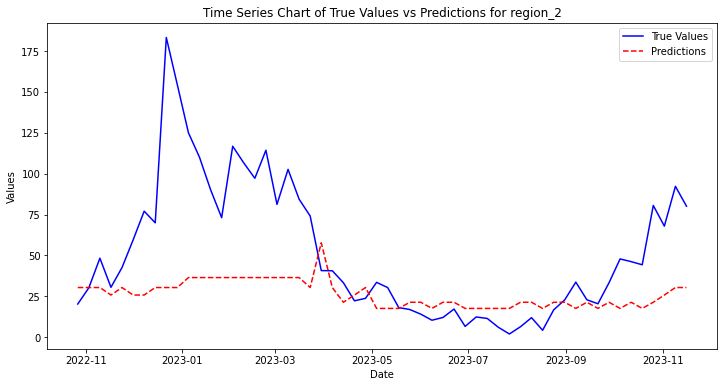

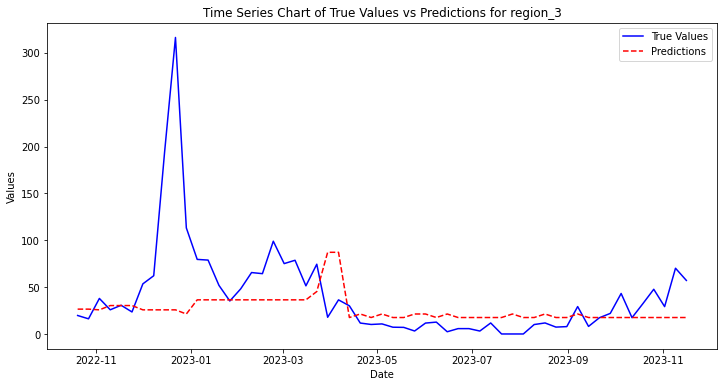

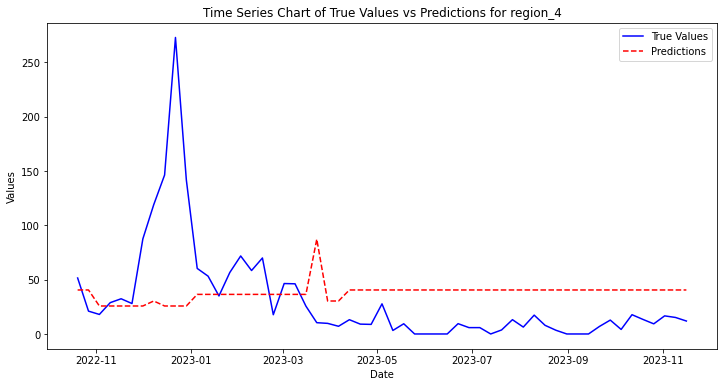

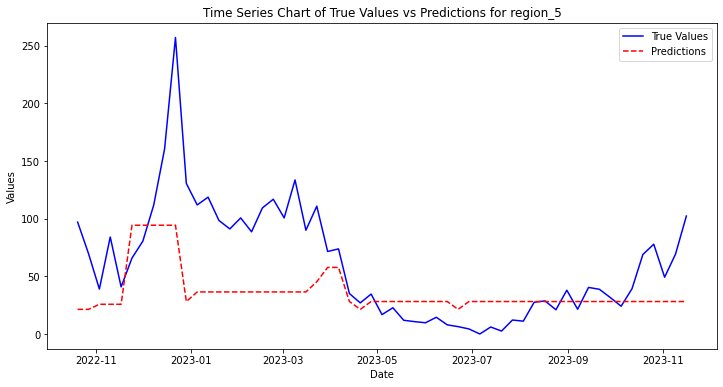

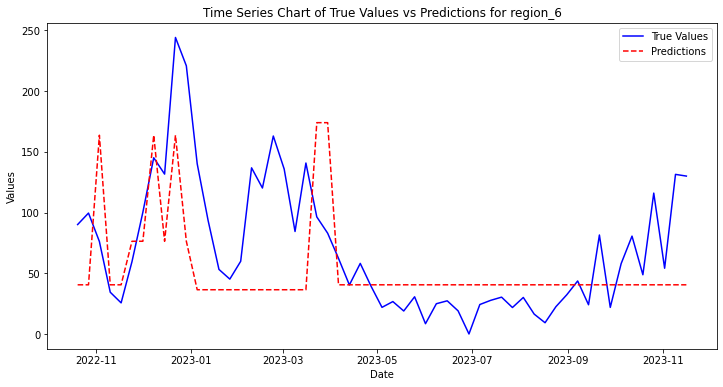

In [214]:
# Stellen Sie sicher, dass df_lagged_with_dummies nach Datum sortiert ist
df_lagged_with_dummies.sort_index(inplace=True)

# Extrahieren Sie die Regionen für den Testdatensatz
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):]

# Erstellen einer Kopie des Slices, um die Warnung zu vermeiden
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):].copy()

# Hinzufügen der Vorhersagen und wahren Werte
test_region_data.loc[:, 'True Values'] = y_test
test_region_data.loc[:, 'Predictions'] = predictions

# Plotten der Ergebnisse für jede Region
unique_regions = ['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6']

for region in unique_regions:
    region_column = 'georegion_' + region
    region_data = test_region_data[test_region_data[region_column] == 1]

    if not region_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(region_data.index, region_data['True Values'], label='True Values', color='blue')
        plt.plot(region_data.index, region_data['Predictions'], label='Predictions', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.title(f'Time Series Chart of True Values vs Predictions for {region}')
        plt.legend()
        plt.show()
    else:
        print(f"Keine Daten für Region {region} gefunden.")


In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Importieren des RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.impute import SimpleImputer

df_lagged_with_dummies.sort_index(inplace=True)

X = df_lagged_with_dummies.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values  # Features
y = df_lagged_with_dummies['incValue'].values  # Zielvariable

# Erstellen eines Imputers, der NaN-Werte durch den Mittelwert der Spalte ersetzt
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Anwenden des Imputers auf Ihr Feature-Array X
X_imputed = imputer.fit_transform(X)

# Jetzt können Sie das train_test_split und das Training des Modells durchführen
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.1, shuffle=False)

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Vorhersagen und Bewertung
predictions = regressor.predict(X_test)
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
print(f"Test-RMSE: {rmse_test}")

mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
print(f"Train-RMSE: {rmse_train}")

Test-RMSE: 42.69757239014866
Train-RMSE: 17.098780340426817


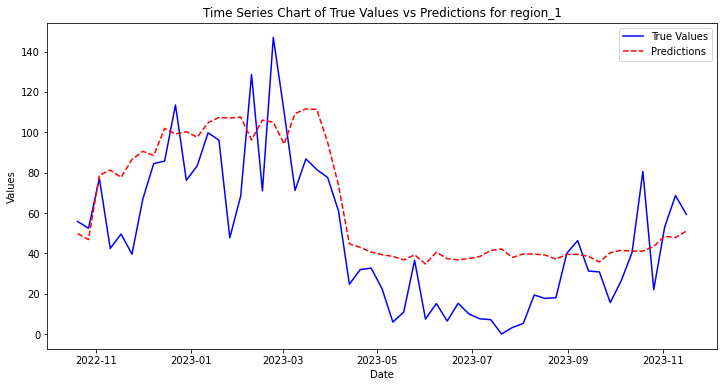

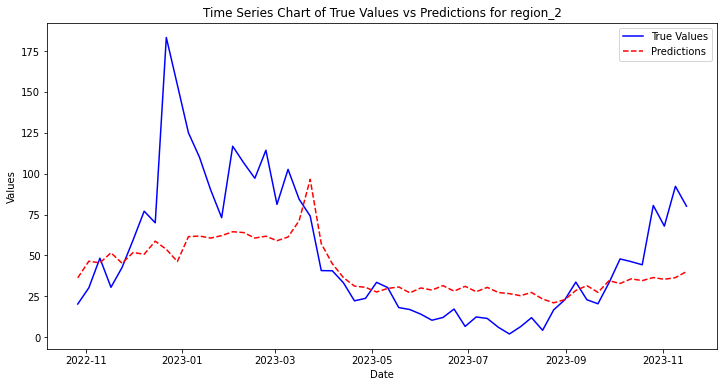

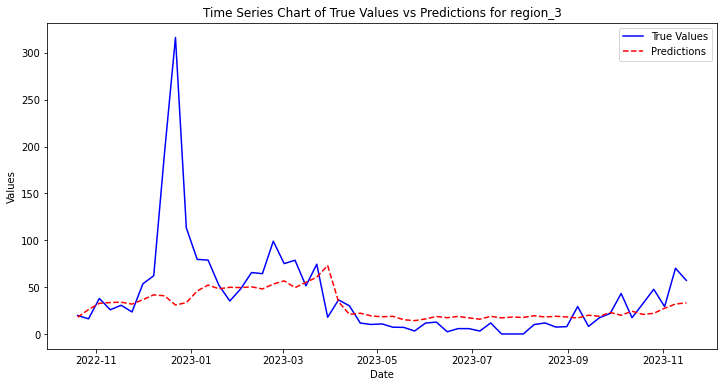

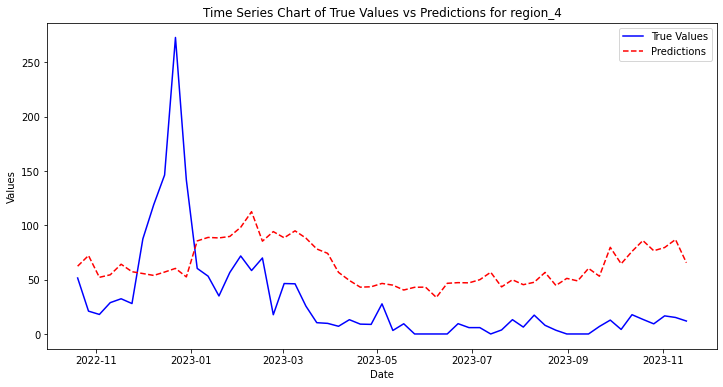

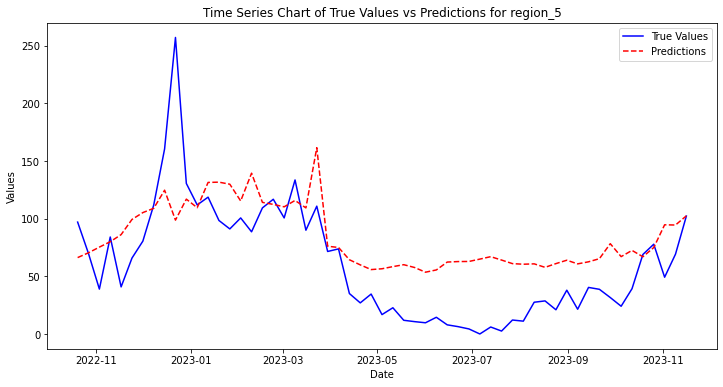

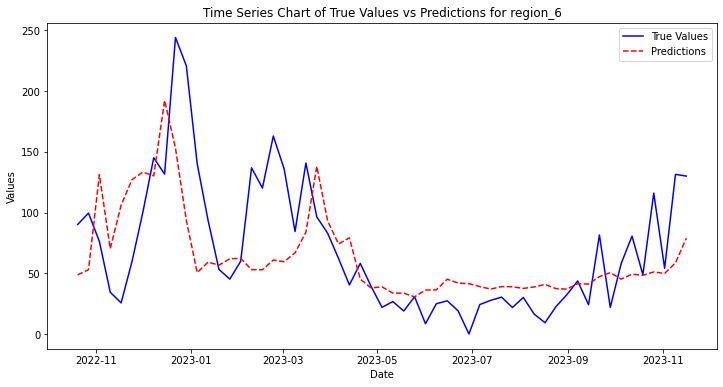

In [222]:
# Stellen Sie sicher, dass df_lagged_with_dummies nach Datum sortiert ist
df_lagged_with_dummies.sort_index(inplace=True)

# Extrahieren Sie die Regionen für den Testdatensatz
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):]

# Erstellen einer Kopie des Slices, um die Warnung zu vermeiden
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):].copy()

# Hinzufügen der Vorhersagen und wahren Werte
test_region_data.loc[:, 'True Values'] = y_test
test_region_data.loc[:, 'Predictions'] = predictions

# Plotten der Ergebnisse für jede Region
unique_regions = ['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6']

for region in unique_regions:
    region_column = 'georegion_' + region
    region_data = test_region_data[test_region_data[region_column] == 1]

    if not region_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(region_data.index, region_data['True Values'], label='True Values', color='blue')
        plt.plot(region_data.index, region_data['Predictions'], label='Predictions', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.title(f'Time Series Chart of True Values vs Predictions for {region}')
        plt.legend()
        plt.show()
    else:
        print(f"Keine Daten für Region {region} gefunden.")


In [219]:
df_lagged_with_dummies

,temporal,flu_cases,incValue,Bevölkerung 1. Januar,Canton Size (km²),weighted_avg_daily_temp_lagged,weighted_avg_daily_hum_lagged,weighted_max_daily_temp_lagged,weighted_min_daily_temp_lagged,weighted_max_daily_hum_lagged,weighted_min_daily_hum_lagged,Flu_lagged,Flu_resid_lagged,Flu_seasonal_lagged,Flu_trend_lagged,Grippe_lagged,Grippe_resid_lagged,Grippe_seasonal_lagged,Grippe_trend_lagged,Influenza_lagged,Influenza_resid_lagged,Influenza_seasonal_lagged,Influenza_trend_lagged,influenza_lagged,influenza_resid_lagged,influenza_seasonal_lagged,influenza_trend_lagged,Fieber_lagged,Fieber_resid_lagged,Fieber_seasonal_lagged,Fieber_trend_lagged,fièvre_lagged,fièvre_resid_lagged,fièvre_seasonal_lagged,fièvre_trend_lagged,husten_lagged,husten_resid_lagged,husten_seasonal_lagged,husten_trend_lagged,toux_lagged,toux_resid_lagged,toux_seasonal_lagged,toux_trend_lagged,Geburten_lagged,Todesfälle_lagged,Überschuss_lagged,Wanderungssaldo international 1_lagged,Wanderungssaldo interkantonal_lagged,total_lagged,% over Year_lagged,Alter 0–19_lagged,Alter 20–64_lagged,Alter 65 und mehr_lagged,Mann_lagged,Frau_lagged,Schweizer_lagged,Ausländer _lagged,Ledig_lagged,Verheiratet_lagged,Verwitwet_lagged,Geschieden_lagged,Unverheiratet_lagged,In eingetragener Partnerschaft_lagged,Aufgelöste Partnerschaft_lagged,Städtischer Kernraum_lagged,Einflussgebiet Stadt_lagged,Ausserhalb des Einflusses städtischer Kerne_lagged,BIP in Millionen CHF_lagged,BIP Growth Laufende Preise_lagged,BIP Growth Preise Vorjahr_lagged,BIP pro Kopf_lagged,Bevölkerung_lagged,% over week_lagged,Pop Density_lagged,week_number,year,flu_cases_lagged,georegion_region_1,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-03,2013-W01,16876.1,53.33,1693743.0,9520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,True,False,False,False,False,False
2013-01-03,2013-W01,8425.9,284.84,535572.0,9917.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,False,False,False,False,False,True
2013-01-03,2013-W01,13560.1,140.12,1350585.0,2750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,False,False,True,False,False,False
2013-01-03,2013-W01,15599.2,96.16,765879.0,4484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,False,False,False,True,False,False
2013-01-03,2013-W01,20530.5,53.58,1354954.0,8469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,NaN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Importieren des RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

df_lagged_with_dummies.sort_index(inplace=True)

X = df_lagged_with_dummies.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values  # Features
y = df_lagged_with_dummies['incValue'].values  # Zielvariable

# Erstellen eines Imputers, der NaN-Werte durch den Mittelwert der Spalte ersetzt
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Anwenden des Imputers auf Ihr Feature-Array X
X_imputed = imputer.fit_transform(X)

# Jetzt können Sie das train_test_split und das Training des Modells durchführen
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.1, shuffle=False)

regressor = RandomForestRegressor()

# cv ist die Anzahl der Folds; hier ein Beispiel mit 5 Folds
scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Berechnung der RMSE für jede Cross-Validation
rmse_scores = np.sqrt(-scores)
print("RMSE für jede Fold:", rmse_scores)
print("Durchschnittlicher RMSE:", np.mean(rmse_scores))

regressor.fit(X_train, y_train)

# Vorhersagen und Bewertung
predictions = regressor.predict(X_test)
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
print(f"Test-RMSE: {rmse_test}")

mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
print(f"Train-RMSE: {rmse_train}")

RMSE für jede Fold: [89.56770035 73.99651148 87.27170016 77.52060046 98.16150106]
Durchschnittlicher RMSE: 85.30360270271909
Test-RMSE: 40.719862327136354
Train-RMSE: 17.323612993657516


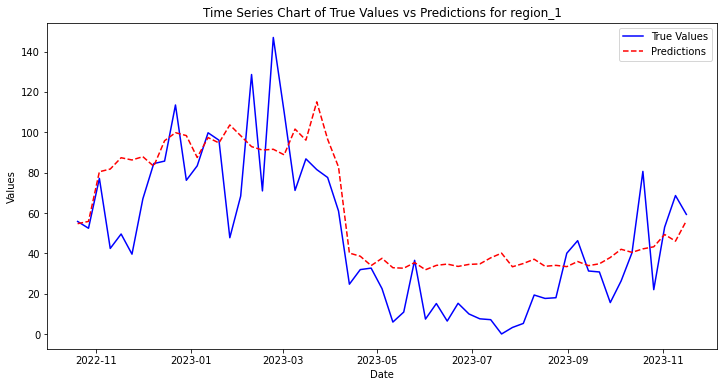

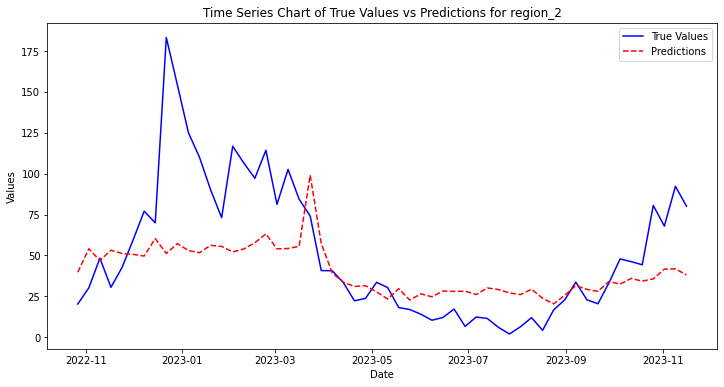

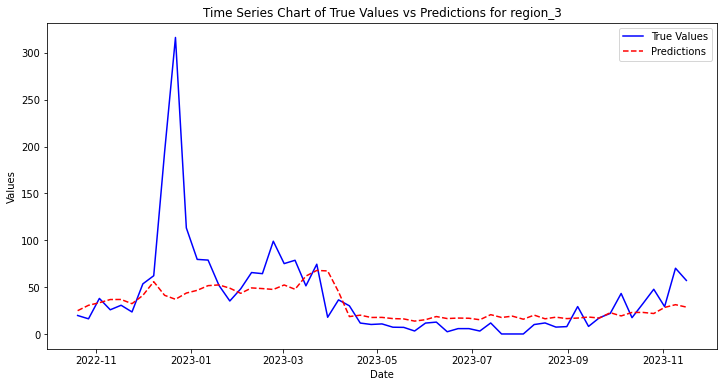

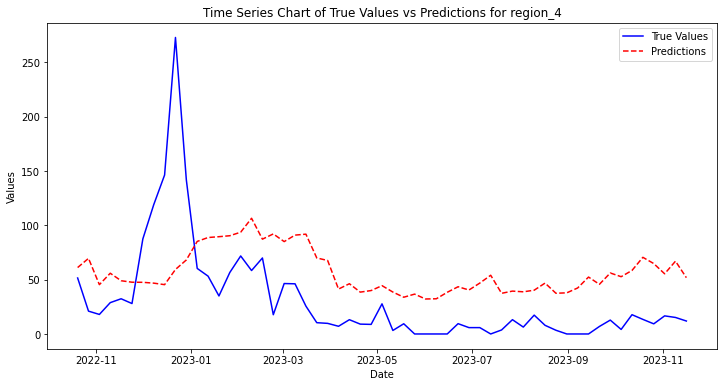

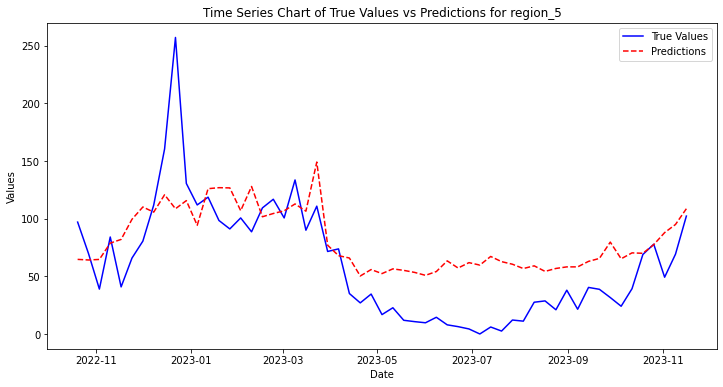

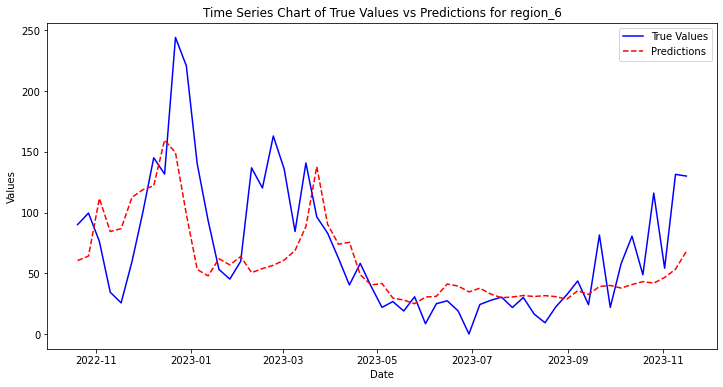

In [226]:
# Stellen Sie sicher, dass df_lagged_with_dummies nach Datum sortiert ist
df_lagged_with_dummies.sort_index(inplace=True)

# Extrahieren Sie die Regionen für den Testdatensatz
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):]

# Erstellen einer Kopie des Slices, um die Warnung zu vermeiden
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):].copy()

# Hinzufügen der Vorhersagen und wahren Werte
test_region_data.loc[:, 'True Values'] = y_test
test_region_data.loc[:, 'Predictions'] = predictions

# Plotten der Ergebnisse für jede Region
unique_regions = ['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6']

for region in unique_regions:
    region_column = 'georegion_' + region
    region_data = test_region_data[test_region_data[region_column] == 1]

    if not region_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(region_data.index, region_data['True Values'], label='True Values', color='blue')
        plt.plot(region_data.index, region_data['Predictions'], label='Predictions', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.title(f'Time Series Chart of True Values vs Predictions for {region}')
        plt.legend()
        plt.show()
    else:
        print(f"Keine Daten für Region {region} gefunden.")


In [228]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_leaf_nodes': [None, 10, 20, 30, 50]
}

# Random Forest Regressor
regressor = RandomForestRegressor()

# Randomized Search
random_search = RandomizedSearchCV(
    regressor, param_distributions, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Training des Randomized Search Modells
random_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("Beste Parameter:", random_search.best_params_)

# Beste Modell bewerten
best_regressor = random_search.best_estimator_
predictions = best_regressor.predict(X_test)
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
print(f"Test-RMSE mit besten Parametern: {rmse_test}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=None, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=None, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=None, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=None, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=None, max_features=0.5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, criterion=sq

In [ ]:
# Stellen Sie sicher, dass df_lagged_with_dummies nach Datum sortiert ist
df_lagged_with_dummies.sort_index(inplace=True)

# Extrahieren Sie die Regionen für den Testdatensatz
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):]

# Erstellen einer Kopie des Slices, um die Warnung zu vermeiden
test_region_data = df_lagged_with_dummies.iloc[-len(X_test):].copy()

# Hinzufügen der Vorhersagen und wahren Werte
test_region_data.loc[:, 'True Values'] = y_test
test_region_data.loc[:, 'Predictions'] = predictions

# Plotten der Ergebnisse für jede Region
unique_regions = ['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6']

for region in unique_regions:
    region_column = 'georegion_' + region
    region_data = test_region_data[test_region_data[region_column] == 1]

    if not region_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(region_data.index, region_data['True Values'], label='True Values', color='blue')
        plt.plot(region_data.index, region_data['Predictions'], label='Predictions', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.title(f'Time Series Chart of True Values vs Predictions for {region}')
        plt.legend()
        plt.show()
    else:
        print(f"Keine Daten für Region {region} gefunden.")
